# SOPHY Database
### Southern Ocean Phytoplankton Database
- UW Oceanography
- Made by Ayush Nag and Hannah Joy-Warren

### Import packages

In [7]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy
import pandas as pd
from pandas import DataFrame
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pyproj
from shapely.ops import transform
from matplotlib.colors import ListedColormap
import matplotlib.path as mpath

In [4]:
zones_shapefile = "../data/shapefiles/zones/so_zones.shp"
sophy_xlsx = "../sophy.xlsx"

### Option 1: Explore data in browser using SQLite and Datasette

In [5]:
# Create sqlite database at sophy.db
conn = sqlite3.connect("sophy.db")
xl = pd.ExcelFile(sophy_xlsx)
for sheet in xl.sheet_names:
    df = pd.read_excel(sophy_xlsx, sheet_name=sheet)
    df.to_sql(sheet, conn, index=False)

In [6]:
!datasette sophy.db -o

INFO:     Started server process [2222]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     127.0.0.1:52158 - "GET /sophy HTTP/1.1" 200 OK
INFO:     127.0.0.1:52158 - "GET /-/static/app.css?d59929 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52161 - "GET /-/static/codemirror-5.57.0.min.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:52162 - "GET /-/static/codemirror-5.57.0.min.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:52163 - "GET /-/static/codemirror-5.57.0-sql.min.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:52164 - "GET /-/static/cm-resize-1.0.1.min.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:52165 - "GET /-/static/sql-formatter-2.3.3.min.js HTTP/1.1" 200 OK
^C
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2222]


### Option 2: SQLite and Pandas (in notebook)
- Use the SQLite database or Excel file
- Opened and closed within this notebook
- Outputs result of queries as DataFrame

In [5]:
# tables = [sample, occurrence, taxonomy, microscopy]
# Query loads all lat, lon from sample and occurrence tables
data: DataFrame = pd.read_sql("select latitude, longitude from sample UNION ALL select latitude, longitude from occurrence;", con=conn)
data

,latitude,longitude
0,47.0132,-19.9849
1,47.0132,-19.9849
2,47.0132,-19.9849
3,47.0132,-19.9849
4,47.0132,-19.9849
...,...,...
94923,-39.9900,95.0100
94924,-43.0000,95.0100
94925,-43.0000,95.0100
94926,-31.7500,95.0000


In [6]:
# Entries in sample grouped by month and year
data = pd.read_sql("select count(*) as entries, strftime('%Y-%m', date_time) as year_month from sample group by year_month", con=conn)
data

,entries,year_month
0,761,1991-11
1,204,1991-12
2,287,1992-01
3,296,1992-02
4,22,1992-10
...,...,...
197,34,2021-01
198,28,2021-02
199,36,2021-03
200,24,2021-04


In [10]:
# sectors: ['Ross', 'BA', 'Weddell', 'Indian', 'WPO']
data = pd.read_sql("select * from sample where sample.chemtax_diatoms > 0.8 and sample.sector == 'BA';", con=conn)
data

,id,source_name,cruise,latitude,longitude,date_time,front_zone,sector,depth,chl_a_fluor,...,hplc_pyrophaeo_a,hplc_pras,hplc_viola,hplc_gyro,hplc_present,chemtax_present,microscopy_present,flowcam_present,ifcb_present,extra_json
0,6742,lter2022,PD91-09,-64.93333,-64.46667,1991-11-11 19:27:00,SIZ,BA,20.2505,0.187000,...,None,0.000000,NaN,None,1,1,1,None,0,"{""BottleNumber"":9.0,""Chlorophyllc2"":0.0235292,..."
1,7633,lter2022,PD93-01,-64.08735,-66.55957,1993-01-11 23:30:00,SIZ,BA,2.2000,NaN,...,None,0.000000,NaN,None,1,1,1,None,0,"{""BottleNumber"":12.0,""Chlorophyllc2"":0.100334,..."
2,10885,lter2022,NBP93-02,-66.25417,-67.34000,1993-04-17 05:03:00,SIZ,BA,110.0000,0.899400,...,None,0.000000,NaN,None,1,1,1,None,0,"{""BottleNumber"":3.0,""Chlorophyllc2"":0.015056,""..."
3,10960,lter2022,NBP93-02,-65.75100,-68.58733,1993-04-18 03:30:00,SIZ,BA,87.0000,0.004500,...,None,0.012034,NaN,None,1,1,1,None,0,"{""BottleNumber"":6.0,""Chlorophyllc2"":0.019999,""..."
4,13743,lter2022,PD94-01,-66.53872,-67.40968,1994-01-29 19:46:00,SIZ,BA,119.8680,0.033200,...,None,0.000000,NaN,None,1,1,1,None,0,"{""BottleNumber"":3.0,""Chlorophyllc2"":0.001958,""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,55245,lter2022,PAL1819,-64.77950,-64.04167,2019-03-28,SIZ,BA,10.0000,3.981370,...,None,0.000000,0.0,None,1,1,1,None,0,"{""Antheraxanthin"":0.0,""BacterialAbundance"":119..."
3425,55246,lter2022,PAL1819,-64.77950,-64.04167,2019-03-28,SIZ,BA,20.0000,4.248492,...,None,0.000000,0.0,None,1,1,1,None,0,"{""Antheraxanthin"":0.0,""BacterialAbundance"":116..."
3426,55247,lter2022,PAL1819,-64.77950,-64.04167,2019-03-28,SIZ,BA,30.0000,4.203132,...,None,0.000000,0.0,None,1,1,1,None,0,"{""Antheraxanthin"":0.0,""BacterialAbundance"":120..."
3427,55248,lter2022,PAL1819,-64.77950,-64.04167,2019-03-28,SIZ,BA,40.0000,3.419936,...,None,0.000000,0.0,None,1,1,1,None,0,"{""Antheraxanthin"":0.0,""BacterialAbundance"":124..."


### Option 3: Excel and Pandas
- Open the sample sheet for main data

In [7]:
sample = pd.read_excel(sophy_xlsx, sheet_name='sample', engine='openpyxl')
sample

,id,source_name,cruise,latitude,longitude,date_time,front_zone,sector,depth,chl_a_fluor,...,hplc_pyrophaeo_a,hplc_pras,hplc_viola,hplc_gyro,hplc_present,chemtax_present,microscopy_present,flowcam_present,ifcb_present,extra_json
0,1,AMT,AMT1,47.01320,-19.98490,1995-09-27 11:00:00,NaN,Weddell,8.4,NaN,...,NaN,0.00000,NaN,NaN,1,0,1,NaN,NaN,"{""BODC_bot_y"":501659.0,""BODC_stn_y"":1502343.0,..."
1,2,AMT,AMT1,47.01320,-19.98490,1995-09-27 11:00:00,NaN,Weddell,20.5,NaN,...,NaN,0.00470,NaN,NaN,1,0,1,NaN,NaN,"{""BODC_bot_y"":501658.0,""BODC_stn_y"":1502343.0,..."
2,3,AMT,AMT1,47.01320,-19.98490,1995-09-27 11:00:00,NaN,Weddell,30.5,NaN,...,NaN,0.00000,NaN,NaN,1,0,1,NaN,NaN,"{""BODC_bot_y"":501657.0,""BODC_stn_y"":1502343.0,..."
3,4,AMT,AMT1,47.01320,-19.98490,1995-09-27 11:00:00,NaN,Weddell,41.3,NaN,...,NaN,0.01344,NaN,NaN,1,0,1,NaN,NaN,"{""BODC_bot_y"":501656.0,""BODC_stn_y"":1502343.0,..."
4,5,AMT,AMT1,47.01320,-19.98490,1995-09-27 11:00:00,NaN,Weddell,50.9,NaN,...,NaN,0.00988,NaN,NaN,1,0,1,NaN,NaN,"{""BODC_bot_y"":501655.0,""BODC_stn_y"":1502343.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55795,55796,lter2022,PAL2021,-64.81500,-64.04050,2021-05-04,SIZ,BA,20.0,0.533521,...,NaN,NaN,NaN,NaN,1,1,1,NaN,0.0,"{""Event"":54.0,""FilterCode"":5.0,""JulianDay"":124..."
55796,55797,lter2022,PAL2021,-64.81500,-64.04050,2021-05-04,SIZ,BA,35.0,0.488506,...,NaN,NaN,NaN,NaN,1,1,1,NaN,0.0,"{""Event"":54.0,""FilterCode"":5.0,""JulianDay"":124..."
55797,55798,lter2022,PAL2021,-64.81500,-64.04050,2021-05-04,SIZ,BA,50.0,0.430152,...,NaN,NaN,NaN,NaN,1,1,1,NaN,0.0,"{""Event"":54.0,""FilterCode"":5.0,""JulianDay"":124..."
55798,55799,lter2022,PAL2021,-64.81500,-64.04050,2021-05-04,SIZ,BA,65.0,0.355125,...,NaN,NaN,NaN,NaN,1,1,1,NaN,0.0,"{""Event"":54.0,""FilterCode"":5.0,""JulianDay"":124..."


<Axes: >

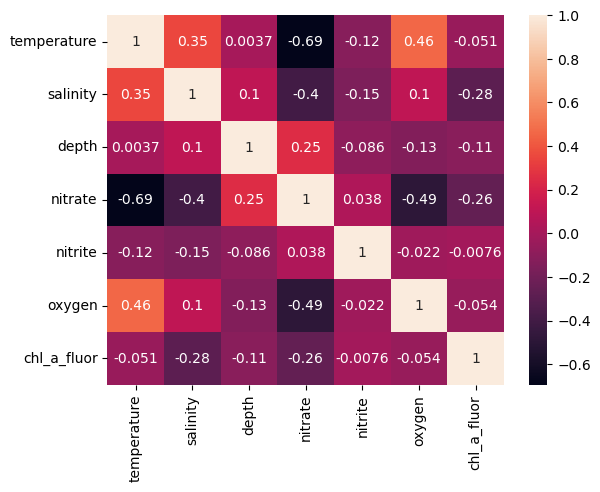

In [10]:
sns.heatmap(sample[["temperature", "salinity", "depth", "nitrate", "nitrite", "oxygen", "chl_a_fluor"]].corr(), annot=True)

### Plot setup

In [11]:
def so_map_ax() -> plt.axes:
    map_proj = ccrs.SouthPolarStereo()
    fig = plt.figure(figsize=[12, 12])  # inches
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    ax.add_feature(cartopy.feature.LAND)
    ax.gridlines(xlocs=[-130, -60, 20, 90, 160], draw_labels=True)
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

def make_sectors() -> gpd.GeoDataFrame:
    project = pyproj.Transformer.from_crs(ccrs.PlateCarree(), ccrs.SouthPolarStereo(), always_xy=True).transform
    # Sectors as shapefiles
    s1 = transform(project, Polygon(zip(np.append(np.linspace(start=-130, stop=-60, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s2 = transform(project, Polygon(zip(np.append(np.linspace(start=-60, stop=20, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s3 = transform(project, Polygon(zip(np.append(np.linspace(start=20, stop=90, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s4 = transform(project, Polygon(zip(np.append(np.linspace(start=90, stop=160, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s5 = transform(project, Polygon(zip(np.append(np.append(np.linspace(start=160, stop=180, num=500), np.linspace(start=-180, stop=-130, num=500)), 0), np.append(np.full(1000, -30), -90))))
    s: list = [s1, s2, s3, s4, s5]
    return gpd.GeoDataFrame(geometry=s, crs=ccrs.SouthPolarStereo())

def my_map() -> ListedColormap:
    # Color shades
    greens  = ['#659222', '#7EA640', '#97BB5E', '#AFCF7D', '#C8E49B', '#E1F8B9']
    yellows = ['#B37707', '#CC8E1B', '#E6A52E', '#FFBC42', '#FFCE75', '#FDE3B1']
    maroons = ['#8F2D56', '#A24C70', '#B66A8B', '#C989A5', '#DDA7C0', '#F0C6DA']
    purples = ['#503E8F', '#6E5EA3', '#8B7FB7', '#A99FCA', '#C6C0DE', '#E4E0F2']
    teals   = ['#218380', '#459B99', '#69B2B3', '#8DCACC', '#B1E1E6', '#D5F9FF']
    greens.reverse(), yellows.reverse(), maroons.reverse(), purples.reverse(), teals.reverse()
    # List of all colors
    color_palette = greens + yellows + maroons + purples + teals
    # Make color palette
    return ListedColormap(sns.color_palette(color_palette).as_hex())

### Plot query on Southern Ocean
- Includes zones and sectors
- Modify the data variable (DataFrame) with queries above and plot here

/Users/ayushnag/miniconda3/envs/sophyvenv/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<GeoAxes: >

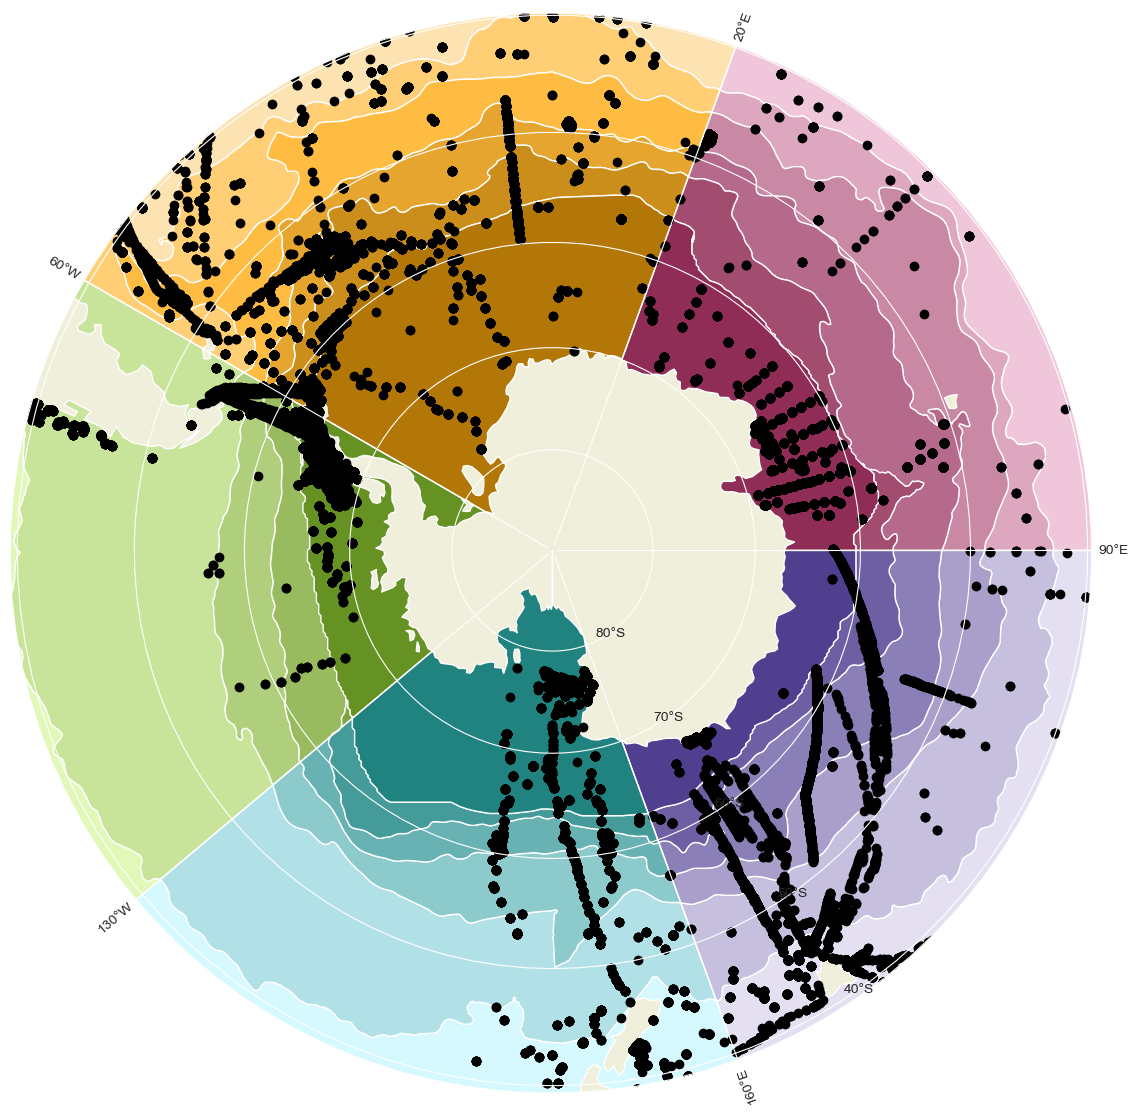

In [16]:
# Generate Southern Ocean plot, GeoDataFrame of sectors, and colormap
ax, sectors, colormap = so_map_ax(), make_sectors(), my_map()
# Get Southern Ocean zones as GeoDataFrame (with shapefiles)
zones: gpd.GeoDataFrame = gpd.read_file(zones_shapefile).to_crs(crs=ccrs.SouthPolarStereo())
# Overlay zones and sectors
res: gpd.GeoDataFrame = zones.overlay(sectors, how='intersection', keep_geom_type=True)
res.plot(ax=ax, cmap=colormap, edgecolor='w', legend=True)
# Plot queried data
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=ccrs.PlateCarree())
data_gdf.to_crs(crs=ccrs.SouthPolarStereo(), inplace=True)
data_gdf.plot(ax=ax, color='k')